In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
endangered = pd.read_csv('./data/endangered_species.csv')
production = pd.read_csv('./data/world_production_new.csv')
threat = pd.read_csv('./data/threatened_species_by_country.csv')


In [4]:
# convert the years that have the format 2014-3 into 2014

def convert_year(year):
	'''
	Converts the year into a consistent format (for example: from 2014-3 to 2014)
	
	year (string): the year to be converted
	return (string): the converted year
	'''
	year = str(year)
	if '-' in year:
		year = year.split('-')[0]
		year = str(int(year))
		return float(year)
	elif '.' in year:
		year = year.split('.')[0]
		year = str(int(year))
		return float(year)
	elif '‐' in year:
		year = year.split('‐')[0]
		year = str(int(year))
		return float(year)
	else:
		return float(year)

endangered['Year'] = endangered['Year'].apply(convert_year)

# replace commas in numbers and turn total column into integers
threat['Total'] = threat['Total'].str.replace(',', '').astype(int)
threat['Plants*'] = threat['Plants*'].str.replace(',', '').astype(int)


In [5]:
# Make a bar graph of the endangered species by year to see data (takes about 5 minutes to run)

#plt.bar(endangered['Year'].astype(str), endangered['Scientific Name'].astype(str), label='Endangered Species')

<BarContainer object of 14 artists>

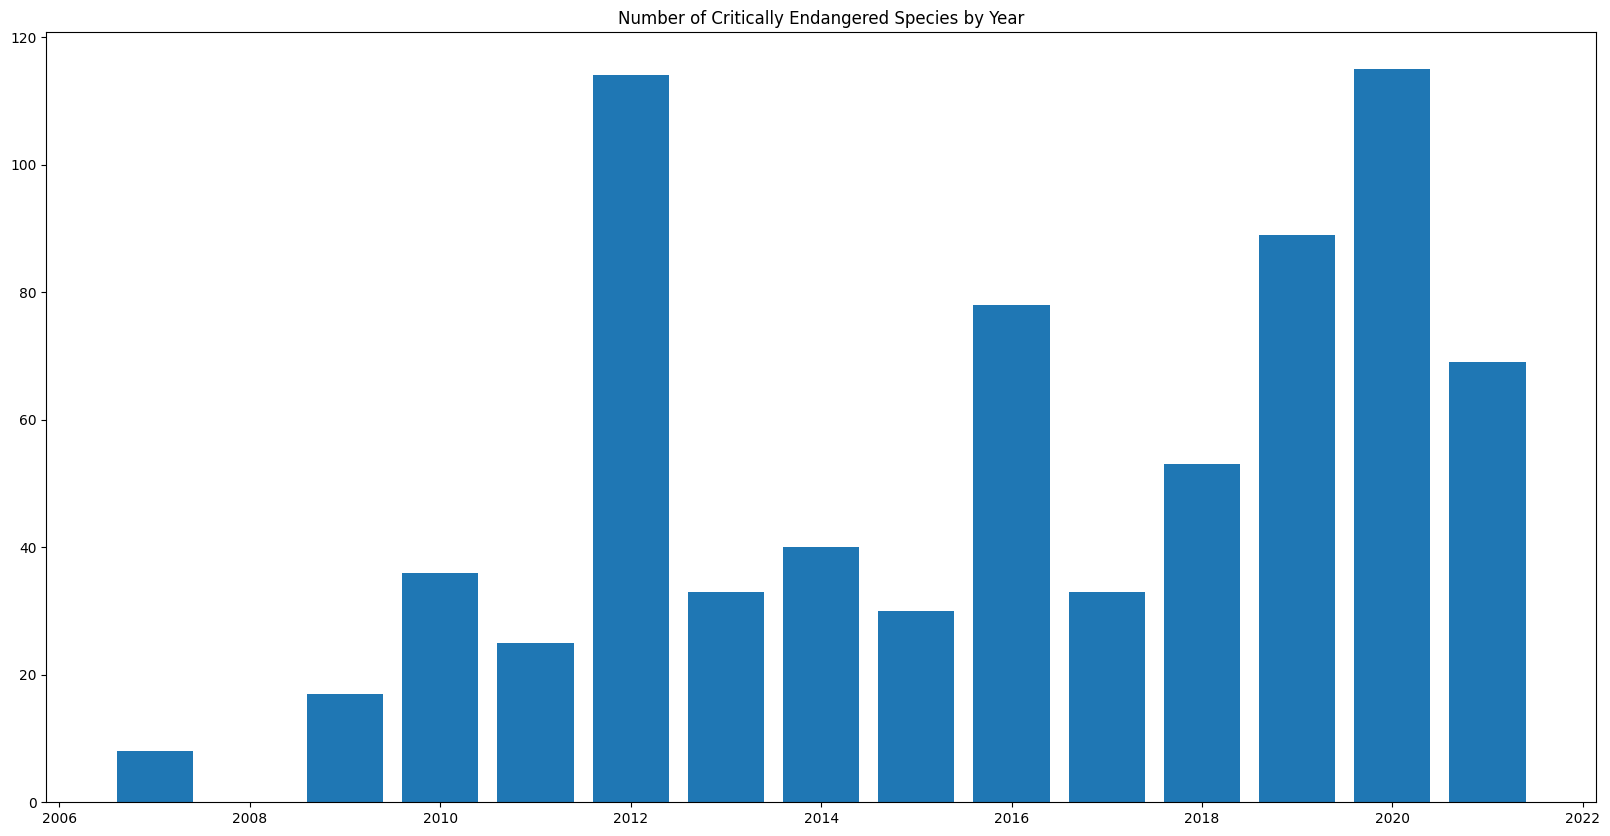

In [34]:
# make a bar graph of the endangered species by year, removing all N and E rows to see data 

# Filter 'endangered' dataframe
endangered_filtered = endangered[endangered['Reason For Change'].isin(['G'])]
endangered_sublist = ['EX', 'EW', 'CR', 'CR(PE)', 'CR(PEW)' 'EN', 'VU', 'NT']

endangered_critically_endangered = endangered_filtered[endangered_filtered['IUCN Red List Category'].isin(endangered_sublist)]

# Group by 'Year' and count number of occurrences
endangered_year = endangered_critically_endangered.groupby('Year')['Scientific Name'].count().astype(int)
endangered_year = endangered_year.reset_index()

# Select only 'Year' and 'Scientific Name' columns
endangered_year_filtered = endangered_year[['Year', 'Scientific Name']]

# Rename 'Scientific Name' column to 'Species Count'
endangered_year_filtered = endangered_year_filtered.rename(columns={'Scientific Name': 'Species Count'})

# Make bar graph
plt.figure(figsize=(20,10))
plt.title('Number of Critically Endangered Species by Year')
plt.bar(x=endangered_year_filtered['Year'], height=endangered_year_filtered['Species Count'])

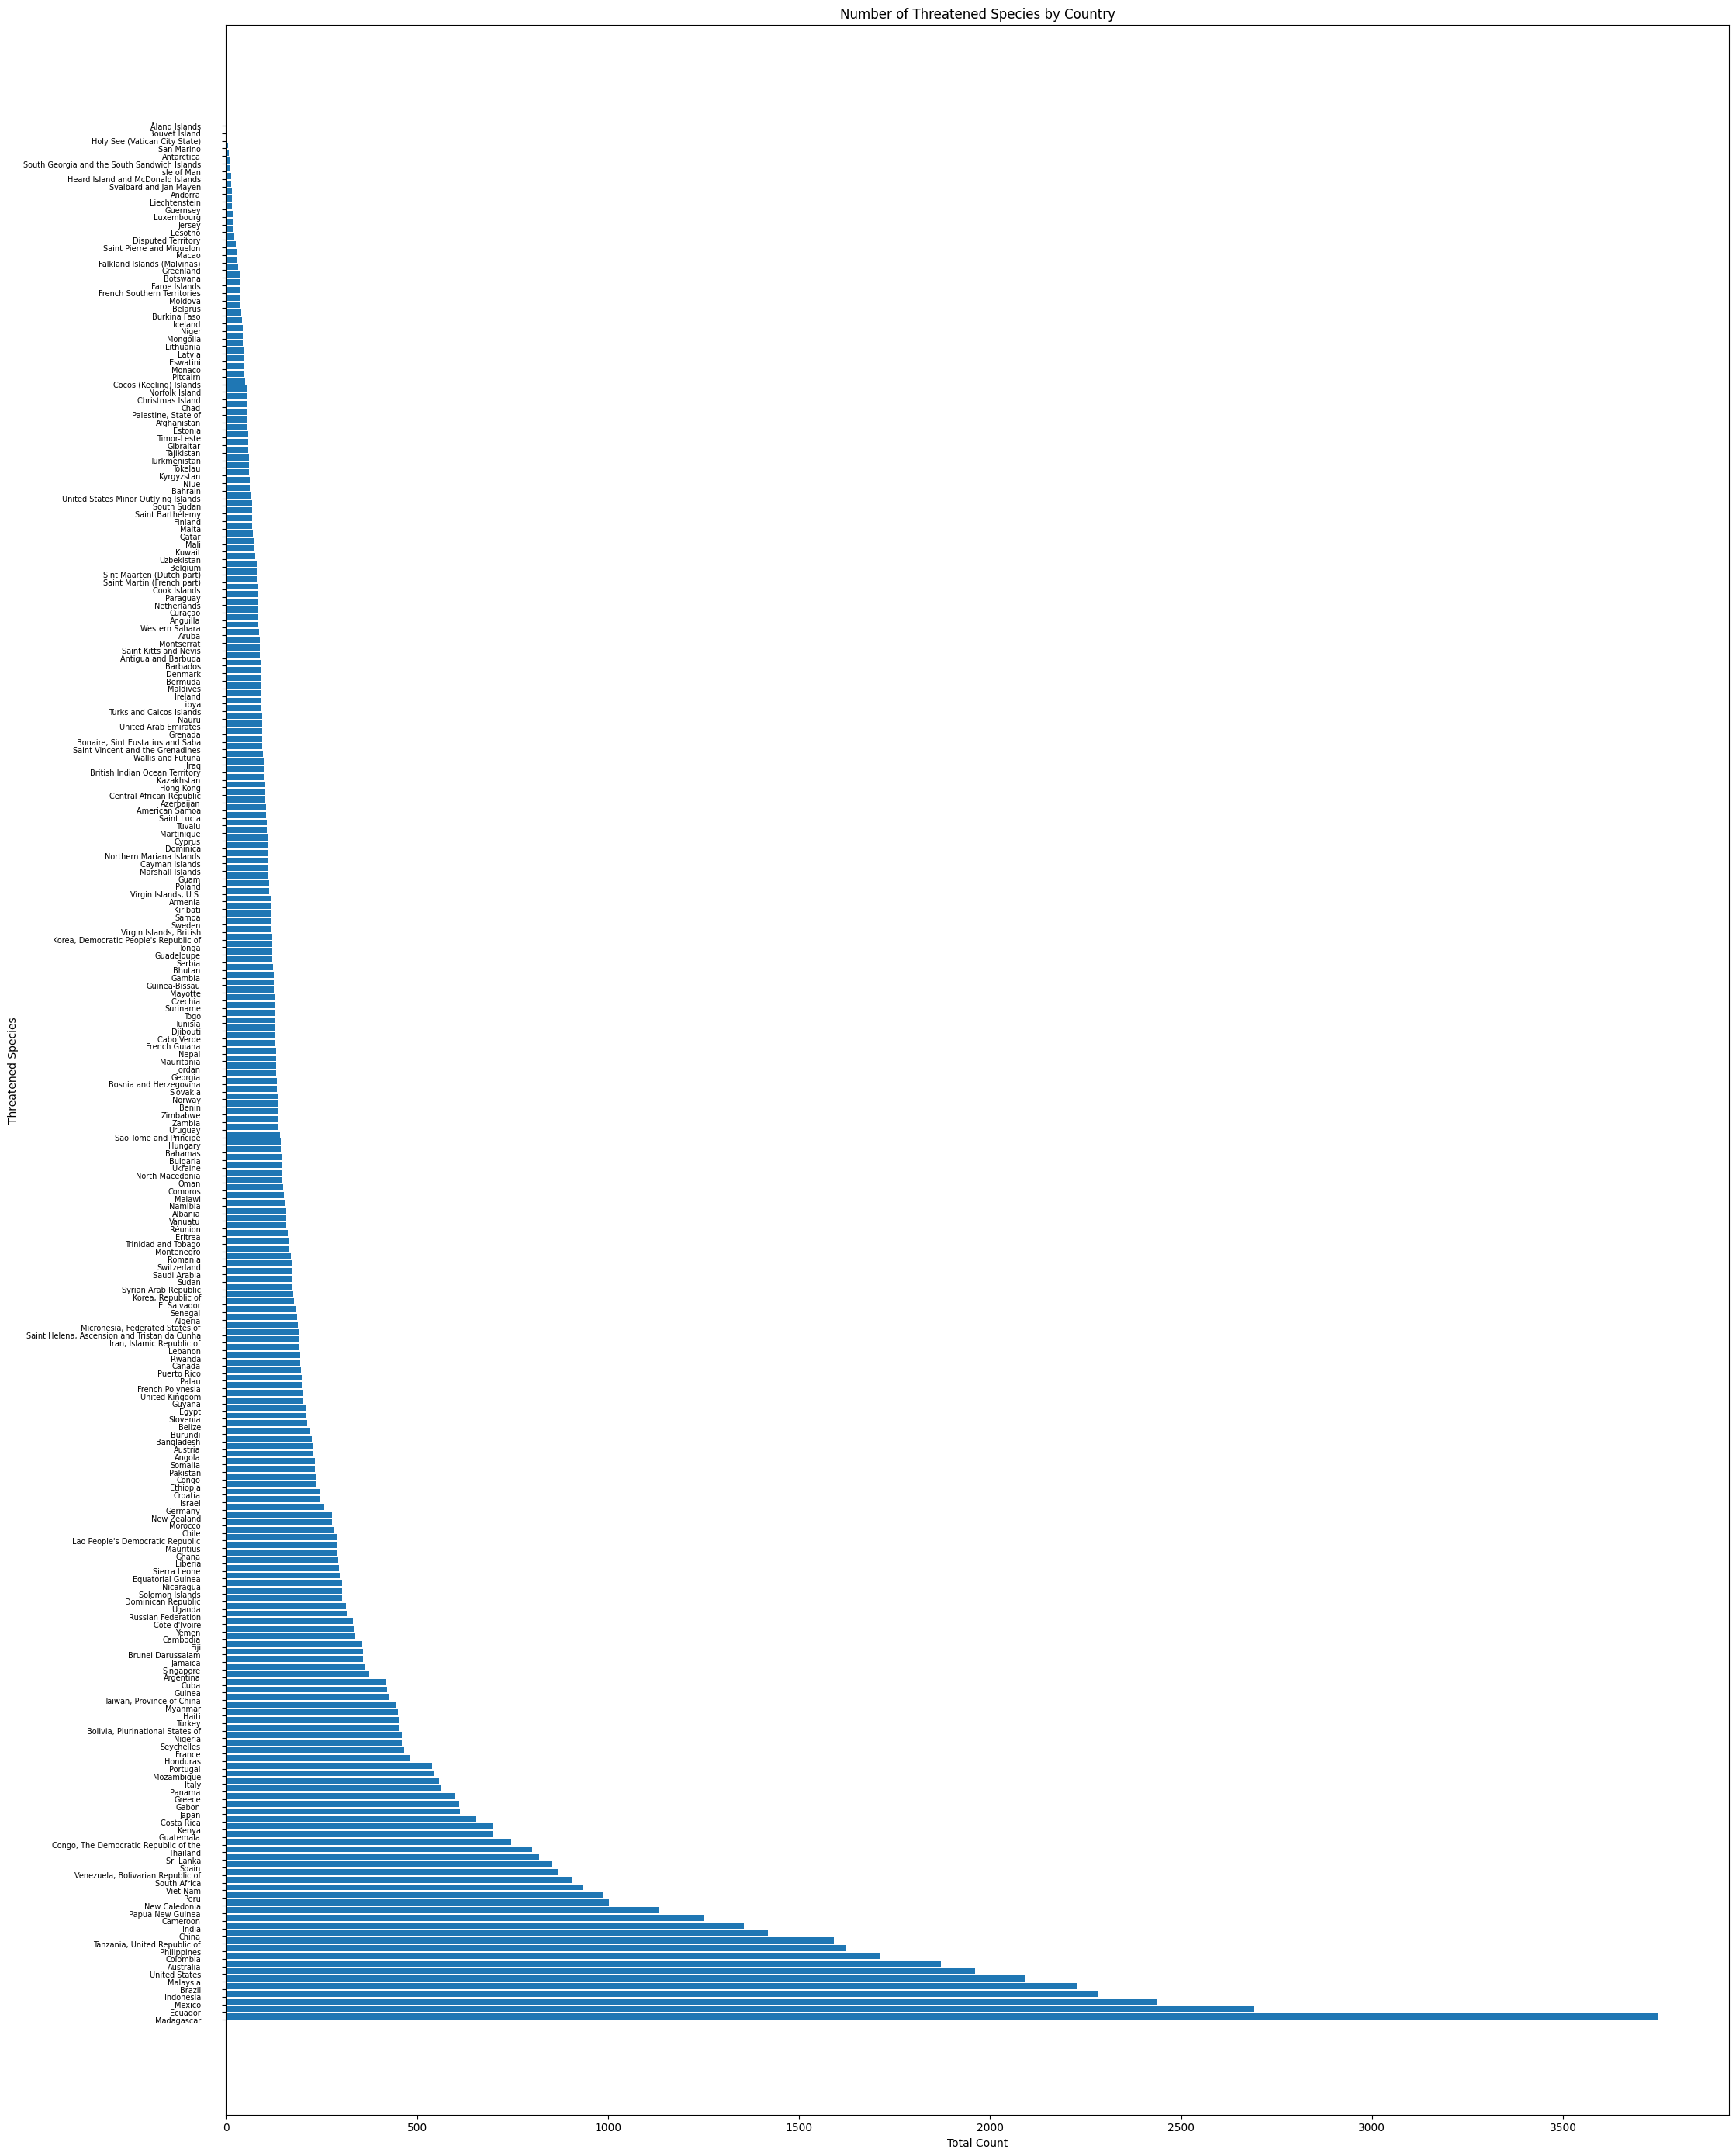

In [7]:
# Make a bar graph of the threatened species by kind to see data

# Group threat dataframe by Name and sum the Total column for each group
threat_filtered = threat.groupby('Name')['Total'].sum().sort_values(ascending=False).reset_index()

# Abbreviate the y-axis tick labels to the first 10 characters
# abbreviated_labels = [label[:10] for label in threat_filtered['Name']]

# Create a horizontal bar graph with abbreviated y-values and widths from the Total column
fig, ax = plt.subplots(figsize=(25, 35))
ax.barh(y=threat_filtered['Name'], width=threat_filtered['Total'], height=0.8, align='edge')

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Count')
ax.set_ylabel('Threatened Species')

# Reduce font size of y-axis tick labels for readability and adjust spacing
ax.tick_params(axis='y', labelsize=7, pad=20)
plt.title('Number of Threatened Species by Country')
plt.show()

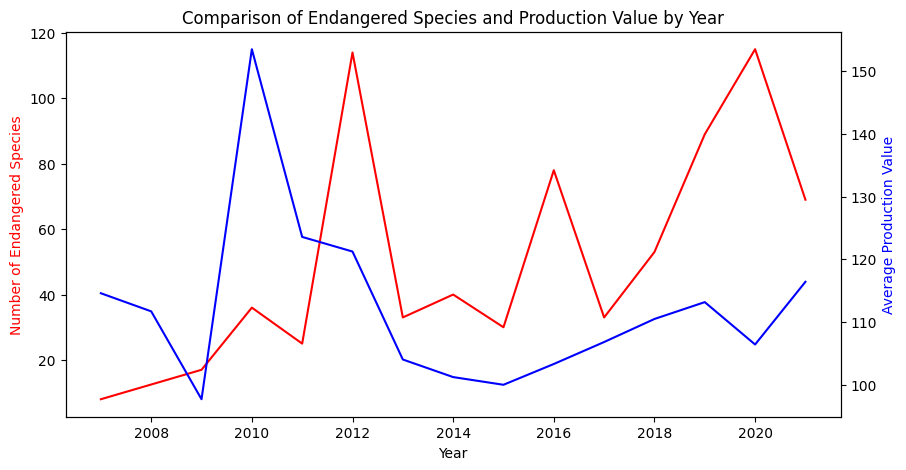

In [35]:
#Compare the average rate of production by year with the number of endangered species by year

# Filter 'production' dataframe by removing 2006 and 2022 and sorting by Year
world_production = production[~production['Year'].isin([2005, 2006, 2022])].reset_index(drop=True)

# Calculate the mean production value by year
world_production_avg = world_production.groupby('Year')['Value'].mean().reset_index()
world_production_avg = world_production_avg.rename(columns={'Value': 'Production Value'})

# Group the endangered species data by year

# Plot the two trends on the same chart
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(endangered_year_filtered['Year'], endangered_year_filtered['Species Count'], color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Endangered Species', color='red')

ax2 = ax1.twinx()
ax2.plot(world_production_avg['Year'], world_production_avg['Production Value'], color='blue')
ax2.set_ylabel('Average Production Value', color='blue')

plt.title('Comparison of Endangered Species and Production Value by Year')
plt.show()


In [18]:
world_production_avg

,Year,Production Value
0,2007,114.597700
1,2008,111.709628
2,2009,97.696496
3,2010,153.514090
4,2011,123.580417
5,2012,121.249908
6,2013,104.031949
7,2014,101.226015
8,2015,99.999957
9,2016,103.314889


/tmp/ipykernel_1488/4248914614.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  production_filtered = production.groupby(['Country Description', 'ISIC Description']).sum().reset_index()


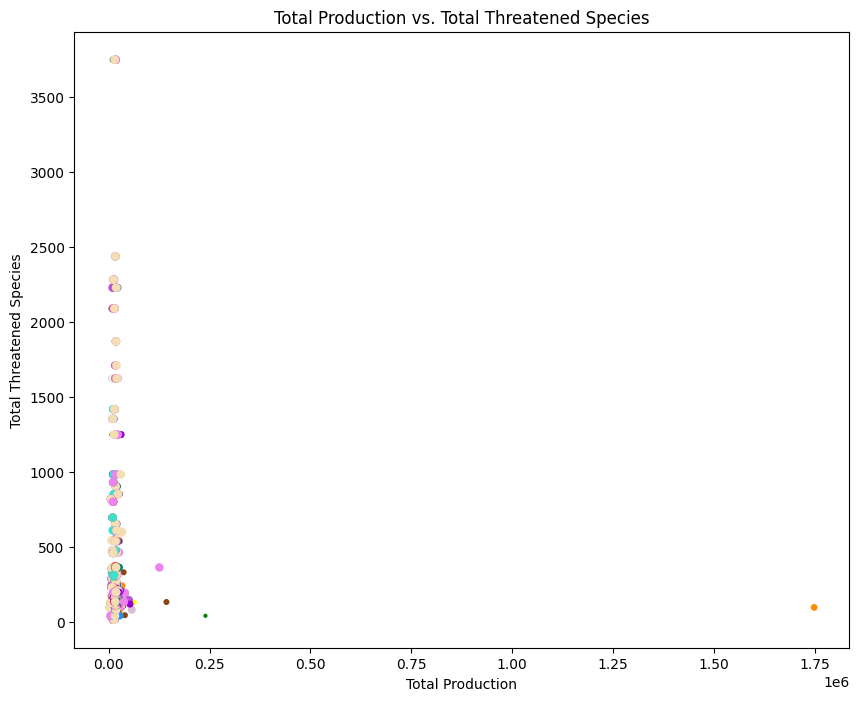

In [10]:
#Compare the type of production in each country with the type of endangered species in each country

# Group production dataframe by Country Description and ISIC Description columns 
production_filtered = production.groupby(['Country Description', 'ISIC Description']).sum().reset_index()

# Pivot threat dataframe to have columns for each threatened species type and values for Total count
# threat_pivot = pd.pivot_table(threat, values='Total', index=['Name'], columns=["Mammals","Birds","Reptiles*","Amphibians","Fishes*","Molluscs*","Other Inverts*","Plants*","Fungi*","Chromists*"], fill_value=0)
threat_f = threat[['Name', "Total"]]

# Join the two dataframes based on the country column
merged_df = pd.merge(production_filtered, threat_f, how='outer', left_on='Country Description', right_on='Name')
merged_df = merged_df.dropna()
merged_df['Total Threatened Species']= merged_df['Total']
merged_df = merged_df.drop(columns=['Name', 'Total'])
# Calculate total production and total threatened species count for each country
# merged_df['Total Production'] = merged_df.iloc[:, 2:].sum(axis=1)
# merged_df['Total Threatened Species'] = merged_df.iloc[:, 3:].sum(axis=1)


# Create a dictionary to define marker sizes based on the type of production
marker_sizes = {'Basic metals': 1,
                'Beverages': 2,
                'Chemicals and chemical products': 3,
                'Coke and refined petroleum products': 4,
                'Computer, electronic and optical products': 5,
                'Electrical equipment': 6,
                'Electricity, gas, steam & air conditioning': 7,
                'Fabricated metal products, except machinery': 8,
                'Food products': 9,
                'Furniture': 10,
                'Leather and related products': 11,
                'Machinery and equipment n.e.c.': 12,
                'Mining and quarrying': 13,
                'Motor vehicles, trailers and semi-trailers': 14,
                'Other manufacturing': 15,
                'Other non-metallic mineral products': 16,
                'Other transport equipment': 17,
                'Paper and paper products': 18,
                'Pharmaceuticals,medicinal chemicals, etc.': 19,
                'Printing and reproduction of recorded media': 20,
                'Rubber and plastics products': 21,
                'Textiles': 22,
                'Tobacco products': 23,
                'Total manufacturing': 24,
                'Water supply; sewerage, waste management': 25,
                'Wearing apparel': 26,
                'Wood products, excluding furniture': 27,
                'Repair and installation of machinery/equipment': 28
                }

# Create a dictionary to define marker colors based on the type of production
marker_colors = {'Basic metals': 'silver',
                 'Beverages': 'blue',
                 'Chemicals and chemical products': 'red',
                 'Coke and refined petroleum products': 'green',
                 'Computer, electronic and optical products': 'yellow',
                 'Electrical equipment': 'purple',
                 'Electricity, gas, steam & air conditioning': 'orange',
                 'Fabricated metal products, except machinery': 'pink',
                 'Food products': 'brown',
                 'Furniture': 'black',
                 'Leather and related products': 'saddlebrown',
                 'Machinery and equipment n.e.c.': 'blue',
                 'Mining and quarrying': 'dimgray',
                 'Motor vehicles, trailers and semi-trailers': 'darkgreen',
                 'Other manufacturing': 'darkorange',
                 'Other non-metallic mineral products': 'darkred',
                 'Other transport equipment': 'darkviolet',
                 'Paper and paper products': 'deeppink',
                 'Pharmaceuticals,medicinal chemicals, etc.': 'dodgerblue',
                 'Printing and reproduction of recorded media': 'snow',
                 'Rubber and plastics products': 'tan',
                 'Textiles': 'teal',
                 'Tobacco products': 'thistle',
                 'Total manufacturing': 'tomato',
                 'Water supply; sewerage, waste management': 'turquoise',
                 'Wearing apparel': 'violet',
                 'Wood products, excluding furniture': 'wheat',
                 'Repair and installation of machinery/equipment': 'mediumorchid',
                 }

# Extract the x, y, size, and color values from the merged_df dataframe
x = merged_df['Value']
y = merged_df['Total Threatened Species']
size = [marker_sizes.get(v, 10) for v in merged_df['ISIC Description']]
color = [marker_colors.get(v, 'black') for v in merged_df['ISIC Description']]

# Plot a scatter plot of all the points at once
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, s=size, c=color)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Production')
ax.set_ylabel('Total Threatened Species')
ax.set_title('Total Production vs. Total Threatened Species')
plt.show()


In [11]:
merged_df

,Country Description,ISIC Description,Country Code,Year,Value,Total Threatened Species
0,Albania,Basic metals,1320.0,332270.0,15091.5,157.0
1,Albania,Beverages,1320.0,332270.0,14887.7,157.0
2,Albania,Chemicals and chemical products,1320.0,332270.0,28343.9,157.0
3,Albania,Coke and refined petroleum products,1320.0,332270.0,28343.9,157.0
4,Albania,"Computer, electronic and optical products",1320.0,332270.0,15091.5,157.0
...,...,...,...,...,...,...
2370,Viet Nam,Textiles,67584.0,193662.0,11312.2,933.0
2371,Viet Nam,Tobacco products,67584.0,193662.0,11591.0,933.0
2372,Viet Nam,Total manufacturing,67584.0,193662.0,12321.0,933.0
2373,Viet Nam,"Water supply; sewerage, waste management",67584.0,193662.0,11275.5,933.0


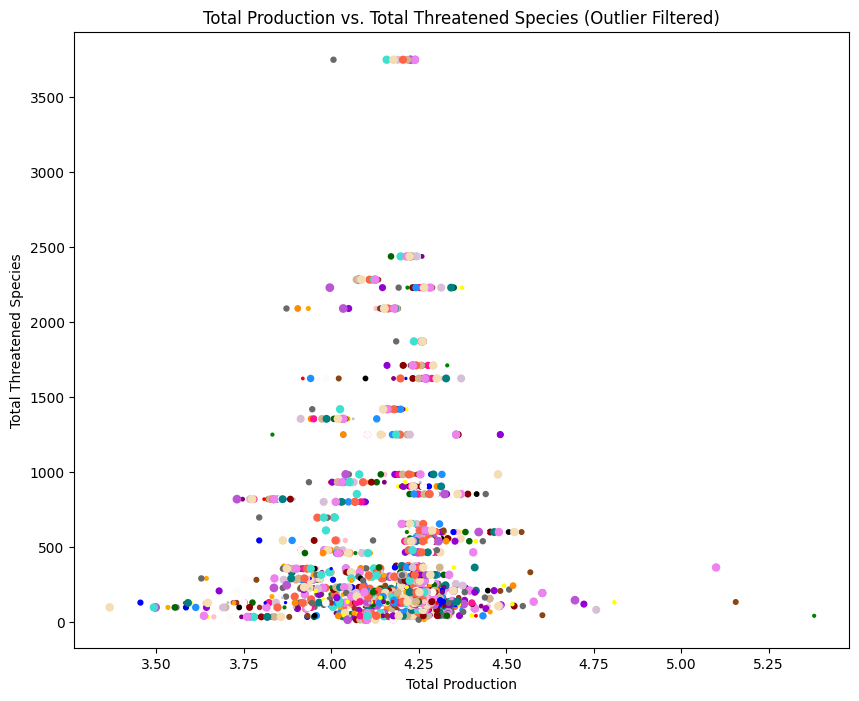

In [12]:
#Chart with outlier filtered out so it is easier to see the rest of the data
merged_df = merged_df[merged_df['Value'] <= 1000000]

# Plot a scatter plot to compare the total production and total threatened species count for each country
# Extract the x, y, size, and color values from the merged_df dataframe
x = merged_df['Value']
y = merged_df['Total Threatened Species']
size = [marker_sizes.get(v, 10) for v in merged_df['ISIC Description']]
color = [marker_colors.get(v, 'black') for v in merged_df['ISIC Description']]

# Plot a scatter plot of all the points
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(np.log10(x), y, s=size, c=color)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Production')
ax.set_ylabel('Total Threatened Species')
ax.set_title('Total Production vs. Total Threatened Species (Outlier Filtered)')


plt.show()


Text(0.5, 1.0, 'Total Production vs. Total Threatened Species (Jittered)')

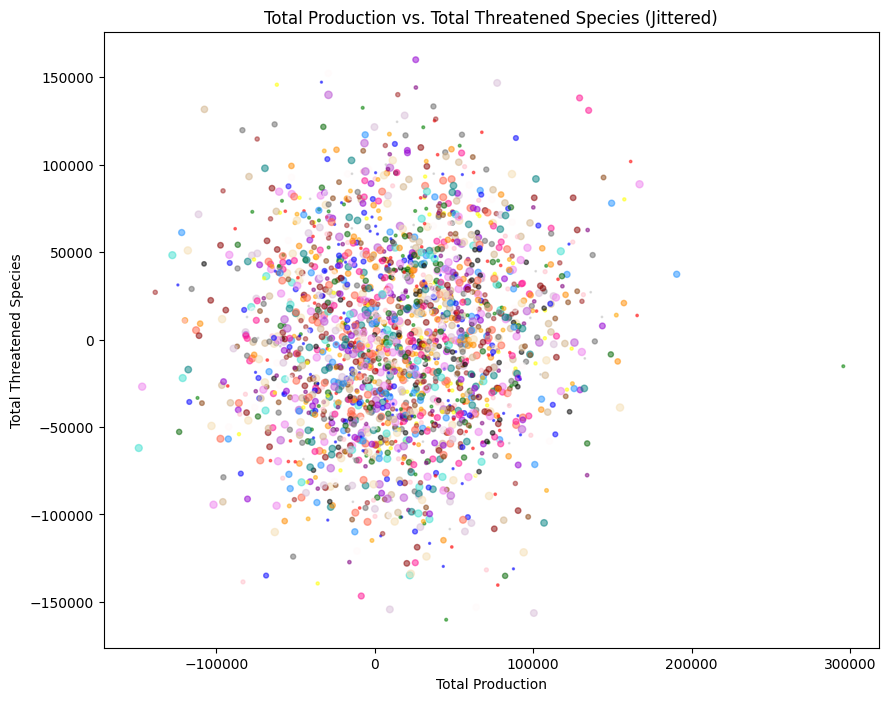

In [13]:
#Make points more visible using transparency and jitter

# Plot a scatter plot to compare the total production and total threatened species count for each country

# Extract x and y values using list comprehension
x_values = [row['Value'] for _, row in merged_df.iterrows()]
y_values = [row['Total Threatened Species'] for _, row in merged_df.iterrows()]

# Generate the random jitter values outside the loop
jitter_values = np.random.randn(len(merged_df), 2) * 50000

# Plot a scatter plot with jittered points
fig, ax = plt.subplots(figsize=(10, 8))
sizes = [marker_sizes.get(row['ISIC Description'], 10) for _, row in merged_df.iterrows()]
colors = [marker_colors.get(row['ISIC Description'], 'black') for _, row in merged_df.iterrows()]
ax.scatter(x_values + jitter_values[:, 0], y_values + jitter_values[:, 1], s=sizes, c=colors, alpha=0.5)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Production')
ax.set_ylabel('Total Threatened Species')
ax.set_title('Total Production vs. Total Threatened Species (Jittered)')

In [14]:
# Import Bokeh modules for interactive plotting
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool

# Enable output in notebook
output_notebook()

Loading BokehJS ...

In [15]:


# Create a data source for the scatter plot
source = ColumnDataSource(data={
    'x': x_values + jitter_values[:, 0],
    'y': y_values + jitter_values[:, 1],
    'size': [marker_sizes.get(row['ISIC Description'], 10) for _, row in merged_df.iterrows()],
    'color': [marker_colors.get(row['ISIC Description'], 'black') for _, row in merged_df.iterrows()],
    'country': [row['Country Description'] for _, row in merged_df.iterrows()],
    'product': [row['ISIC Description'] for _, row in merged_df.iterrows()]
})

# Set up the figure and add a scatter plot
fig = figure(title='Scatter Plot', width=800, height=600)
fig.scatter('x', 'y', size='size', color='color', alpha=0.5, source=source)

# Set labels for the x-axis and y-axis
fig.xaxis.axis_label = "Total Production"
fig.yaxis.axis_label = "Total Threatened Species"
fig.title.text = "Total Production vs. Total Threatened Species (Jittered)"

# Add a hover tooltip that shows the country name
hover = HoverTool(tooltips=[("Country", "@country"), ("Total Production", "@x"), ("Total Threatened Species", "@y"), ("Industry", "@product")])
fig.add_tools(hover)


show(fig)

In [16]:
# Create a data source for the scatter plot
source = ColumnDataSource(data={
    'x': x_values,
    'y': y_values,
    'size': [marker_sizes.get(row['ISIC Description'], 10) for _, row in merged_df.iterrows()],
    'color': [marker_colors.get(row['ISIC Description'], 'black') for _, row in merged_df.iterrows()],
    'country': [row['Country Description'] for _, row in merged_df.iterrows()],
    'product': [row['ISIC Description'] for _, row in merged_df.iterrows()]
})

# Set up the figure and add a scatter plot
fig = figure(title='Scatter Plot', width=800, height=600)
fig.scatter('x', 'y', size='size', color='color', alpha=0.5, source=source)

# Set labels for the x-axis and y-axis
fig.xaxis.axis_label = "Total Production"
fig.yaxis.axis_label = "Total Threatened Species"
fig.title.text = "Total Production vs. Total Threatened Species"

# Add a hover tooltip that shows the country name
hover = HoverTool(tooltips=[("Country", "@country"), ("Total Production", "@x"),
                  ("Total Threatened Species", "@y"), ("Industry", "@product")])
fig.add_tools(hover)


show(fig)
